In [1]:
from collections import defaultdict
from typing import Tuple
import numpy as np
import pandas as pd

# Symbolic Defaults by 'complexity' of expression
In this notebook we take a look at the results of running the script at its default settings, this means:
 - evaluation across all tasks
 - recording the pareto front of symbolic defaults after each search
 - evaluating in-sample and out-of-sample performance of those dynamic defaults, as well as some pre-defined ones
 
**note:** The console cut off results for the first few tasks, so I am rerunning those now.

In [43]:
with open('runs/knn.log') as fh:
    lines = fh.readlines()

In [44]:
# saved because it's useful later, moreso than now.
first_definition = [i for i, line in enumerate(lines) if ':=' in line][0]

print("The predefined defaults are:")
for line in lines[first_definition:]:
    if ':=' in line:
        print(f" * {line[len('INFO:root:'):-1]}")

The predefined defaults are:
 * t := make_tuple(1., 16., 10., 200.)


In [45]:
benchmarks = ["const", "sklearn_scale", "symbolic_best", "symbolic_v2"]
benchmarks = ["mlr_default"]

In [46]:
task_starts = [i for i, line in enumerate(lines) if "INFO:root:START_TASK:" in line]
in_sample_starts = [i for i, line in enumerate(lines) if "INFO:root:Evaluating in sample:" in line]
out_sample_starts = [i for i, line in enumerate(lines) if "INFO:root:Evaluating out-of-sample:" in line]

In [47]:
task_starts = [i for i, line in enumerate(lines) if "START_TASK:" in line]
in_sample_starts = [i for i, line in enumerate(lines) if "Evaluating in sample:" in line]
out_sample_starts = [i for i, line in enumerate(lines) if "Evaluating out-of-sample:" in line]

For each task we will extract:
 - the number of generations optimization ran for (max=200)
 - max length expression
 - in and out of sample performance for length 1, 2 and 3 expression

In [48]:
def parse_evaluation_line(line) -> Tuple[str, int, float]:
    """ Parse an evaluation line, returning the expression or name, its 'length' and the score.
    
    e.g. INFO:root:[make_tuple(p, mkd)|0.8893]\n -> 'make_tuple(p, mkd)', 1, 0.8893 
    Length is 0 for benchmark problems.
    """
    start, pipe, end = line.find('['), line.find('|'), line.find(']')
    expression = line[start + 1 : pipe]
    expression_length = expression.count('(')
    return expression, expression_length, float(line[pipe + 1 : end])

For each task save the benchmark results. We also save results for length 1, 2 and 3 solutions as well as the best one found (that may be longer). Specifically we record:
 - best in_sample performance at length 1, 2, 3
 - best in_sample performance for any length
 - average out_sample performance by length for length 1, 2, 3
 - average out_sample performance for the longest (i.e. best in-sample score) solution(s).

In [49]:
tasks = [int(line[:-1].split(": ")[-1]) for line in lines if "START_TASK:" in line]
idx = pd.MultiIndex.from_product([tasks, ["in-sample", "out-sample"]], names=['task', 'sample-type'])
df = pd.DataFrame(index=idx, columns=["score-1","score-2", "score-3", "score-best", *benchmarks], dtype=float)

In [50]:
expressions_by_length = defaultdict(list)
generations_by_task = {}

for task_start, in_start, out_start, next_task in zip(task_starts, in_sample_starts, out_sample_starts, task_starts[1:] + [first_definition]):
    # start line looks like: INFO:root:START_TASK: 29\n
    task = int(lines[task_start][:-1].split(": ")[-1])
    
    # Since the in-sample evaluation message follows directly after optimization is done, we use that to record
    # the number of generations. We account for the early stopping message if it did not run to 200 generations.
    ended_early = 0 if in_start - task_start == 201 else - 1
    generations_by_task[task] = in_start - (task_start + 1) - ended_early
    
    # Following the "INFO:root:Evaluating in sample:" message, symbolic default performance are printed
    # They are formatted as "INFO:root:[make_tuple(p, mkd)|0.8893]"
    # First is any number of best solutions from the pareto front. The last four are benchmark solutions.
    # It is possible that two equally good solutions are printed (i.e. same length and performance).    
    expr_in_task = set()
    
#     in_sample_evaluation_lines = lines[in_start + 1 : out_start]
#     in_sample_evaluations = [parse_evaluation_line(eval_) for eval_ in in_sample_evaluation_lines]
#     max_len = max([len_ for _, len_, _ in in_sample_evaluations])
#     expr_in_task = {expr for expr, _, _ in in_sample_evaluations}
    max_length = 0
    
    for in_sample_evaluation in lines[in_start + 1 : out_start]:
        expr, length, score = parse_evaluation_line(in_sample_evaluation)
        # Pareto fronts may contain literal duplicates, so we filter those out manually.
        if expr not in expr_in_task:
            expressions_by_length[length].append(expr)
            expr_in_task.add(expr)
        
        if length !=0:
            if length < 4:
                # Only report one out-of-sample solution for each length (and all benchmarks), so overwrite is OK.
                df.loc[task, "in-sample"][f"score-{length}"] = score
                
            # Update best so far score and maximum length
            df.loc[task, "in-sample"][f"score-best"] = np.nanmax([score, df.loc[task, "in-sample"][f"score-best"]])
            max_length = max(max_length, length)
        else:
            df.loc[task, "in-sample"][expr] = score
            
        if length > max_length:
            max_length = length  # To know for which length "best" should score out of sample
    
    # Because two equal solutions can be in the Pareto front, 
    # we note the average out of sample performance if multiple solutions were found.
    # Naturally, the solutions with the best in-sample score were those with the highest length in the Pareto front.
    
    scores_by_length = defaultdict(list)
    
    for out_sample_evaluation in lines[out_start + 1 : next_task]:
        expr, length, score = parse_evaluation_line(out_sample_evaluation)   
        if length !=0:
            scores_by_length[length].append(score)
        else:
            df.loc[task, "out-sample"][expr] = score
            
    for length, scores in scores_by_length.items():
        if length < 4:
            df.loc[task, "out-sample"][f"score-{length}"] = np.mean(scores)
        if length == max_length:
            df.loc[task, "out-sample"][f"score-best"] = np.mean(scores)
        if np.mean(scores) == float("nan"):
            print('hi')
    

In [51]:
for length, expressions in sorted(expressions_by_length.items()):
    m = max(set(expressions), key=expressions.count)
    print(f" Found {len(expressions):3d} expressions of length {length}. Most frequent: {m} ({expressions.count(m)} times)")

 Found 116 expressions of length 0. Most frequent: mlr_default (116 times)
 Found 475 expressions of length 1. Most frequent: make_tuple(9.0, n, 256.0, 256.0) (83 times)
 Found 245 expressions of length 2. Most frequent: make_tuple(9.0, truediv(256.0, m), 256.0, 256.0) (19 times)
 Found 167 expressions of length 3. Most frequent: make_tuple(9.0, 512.0, sub(n, 512.0), truediv(256.0, xvar)) (3 times)
 Found 107 expressions of length 4. Most frequent: make_tuple(9.0, mul(mcp, 256.0), mul(0.015625, add(p, n)), 1024.0) (1 times)
 Found  74 expressions of length 5. Most frequent: make_tuple(9.0, truediv(1024.0, neg(sub(m, 5.0))), truediv(n, 9.0), 1024.0) (1 times)
 Found  56 expressions of length 6. Most frequent: make_tuple(9.0, 256.0, sub(n, 512.0), truediv(truediv(256.0, mcp), min(mcp, sub(n, 512.0)))) (1 times)
 Found  31 expressions of length 7. Most frequent: make_tuple(9.0, n, max(max(128.0, truediv(pow(p, xvar), mcp)), truediv(p, sub(mcp, xvar))), 1024.0) (1 times)
 Found  15 express

"Found `N` expressions of length `L`" here means across all the tasks' pareto fronts `N` solutions have length `L`.
Pareto fronts may contain duplicate entries.

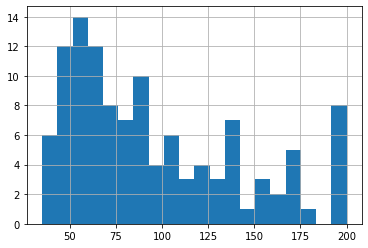

In [52]:
pd.Series(generations_by_task, name="generations").hist(bins=20)

Above plot shows the histogram of the number of generations across tasks (binsize=10).
Note that if something ran for less than 200 generations, it found its optimum 20 generations earlier and early stopping terminated search.

In [53]:
df

score-1  score-2  score-3  score-best  mlr_default
task   sample-type                                                    
3      in-sample     0.7703   0.7711   0.7716      0.7719       0.5021
       out-sample    0.8705   0.8705   0.8731      0.8731       0.1286
6      in-sample     0.7706   0.7712      NaN      0.7712       0.4951
       out-sample    0.8295   0.8293      NaN      0.8293       0.9370
11     in-sample     0.7698   0.7708   0.7711      0.7715       0.5020
...                     ...      ...      ...         ...          ...
189927 out-sample    0.8339   0.8414   0.8414      0.8414       0.0219
189928 in-sample     0.7700   0.7744   0.7751      0.7756       0.4977
       out-sample    0.9075   0.9075   0.9093      0.9100       0.6381
190411 in-sample     0.7702   0.7714      NaN      0.7714       0.5021
       out-sample    0.8110   0.8110      NaN      0.8110       0.1313

[232 rows x 5 columns]

In [54]:
out_sample = df.index.map(lambda idx: idx[1] == "out-sample")
df.loc[out_sample]

,,score-1,score-2,score-3,score-best,mlr_default
task,sample-type,,,,,
3,out-sample,0.8705,0.8705,0.8731,0.8731,0.1286
6,out-sample,0.8295,0.8293,NaN,0.8293,0.9370
11,out-sample,0.9207,0.8974,0.9020,0.8895,0.1472
12,out-sample,0.8328,0.8467,0.8467,0.8467,0.8921
14,out-sample,0.8229,0.8471,NaN,0.8471,0.3793
...,...,...,...,...,...,...
168912,out-sample,0.8768,0.8768,NaN,0.8768,0.5460
189924,out-sample,0.7088,0.7002,0.6948,0.6948,0.0941
189927,out-sample,0.8339,0.8414,0.8414,0.8414,0.0219


We compare the scores and note which solution leads to the best out of sample score per task. A solution wins **alone** if all other solutions have worse performance. It wins **shared** if at least one other solution has the same score, but no solution has a better score. **either** is the sum of alone and shared.

In [55]:
alone = defaultdict(int)
shared = defaultdict(int)
for _, out in df.loc[out_sample].iterrows():
    best = out[out == out.max()].index.values
    if len(best) == 1:
        alone[best[0]] += 1
    else:
        for winner in best:
            shared[winner] += 1

In [56]:
alone = {k: alone[k] for k in sorted(alone)}
shared = {k: shared[k] for k in sorted(shared)}
either = {k: shared[k] + alone[k] for k in sorted(shared)}
pd.DataFrame([alone, shared, either], index=['alone', 'shared', 'either'])

,mlr_default,score-1,score-2,score-3,score-best
alone,36.0,19,5,3,6
shared,NaN,28,35,30,39
either,NaN,47,40,33,45


But tallying wins does not say much about the robustness of the symbolic defaults. We can also compare the average or median distance from the top performer:

In [57]:
df_out = df.loc[out_sample].copy()

In [58]:
df_out['max'] = df_out.max(axis=1)
for col in df_out:
    df_out['d_'+col] = df_out['max'] - df_out[col]

In [59]:
d_cols = [c for c in df_out.columns if c.startswith('d_')]
df_out[d_cols].mean()

d_score-1        0.083527
d_score-2        0.080796
d_score-3        0.079558
d_score-best     0.081667
d_mlr_default    0.349429
d_max            0.000000
dtype: float64

In [60]:
df_out[d_cols].median()

d_score-1        0.00190
d_score-2        0.00150
d_score-3        0.00180
d_score-best     0.00115
d_mlr_default    0.34560
d_max            0.00000
dtype: float64

Looking at in-sample performance:

In [61]:
in_sample = df.index.map(lambda idx: idx[1] == "in-sample")
df.loc[in_sample].idxmax(axis=1).value_counts()

score-best    54
score-2       34
score-3       28
dtype: int64

`idxmax` reports the first column that has a max score of the row. So we see that never is the "score-1" solution the best in-sample. It is divided somewhat evenly between score-2, score-3 and scores for greater lengths. In 15 of 106 cases, it does not find the solution "symbolic best", which would have had better in-sample performance for that task (for other tasks we don't know if it was considered).

Reversing column order, we confirms there are no ties between any found solutions and benchmark ones (in-sample):

In [62]:
df.loc[in_sample][reversed(df.columns)].idxmax(axis=1).value_counts()

score-best    116
dtype: int64

In [63]:
df.loc[in_sample][reversed(df.columns)].idxmax(axis=1)

task    sample-type
3       in-sample      score-best
6       in-sample      score-best
11      in-sample      score-best
12      in-sample      score-best
14      in-sample      score-best
                          ...    
168912  in-sample      score-best
189924  in-sample      score-best
189927  in-sample      score-best
189928  in-sample      score-best
190411  in-sample      score-best
Length: 116, dtype: object